# Analysis for Rodent Activity Detector (RAD) device
## Nanami Miyazaki (Kravitz lab, NIDDK)


# Overview of the code & experimental design
The purpose of this code is to analyze data collected from the RAD device. The RAD device is a small device that measures locomotor activity of animals (in this case, mice) in their home cage over extended periods of time. Locomotor activity is measured by a passive infrared (PIR) sensor which measures the number of bouts (PIR count) and the number of seconds (PIR duration) an animal is active in a 1-minute time window. 

For this experiment, locomotor activity of 19 mice were measured for 15 weeks. The first 3 weeks were considered a baseline period in which all mice received regular chow diet. The remaining 12 weeks, 9 mice received a high-fat diet (HFD) and 10 mice received the regular chow diet. The purpose of the experiment is to observe the effects of HFD on mouse locomotor behavior over time.

# Rodent Activity Detector (RAD) device
- Goal: Measure locomotor activity of 19 mice for 12 continuous weeks 
- Current Methods:
    - Open-field mazes
    - Running wheels 
- Small device developed in the Kravitz lab
    - Compact design compatible with home cages for longitudinal recordings
    - Relatively hands-free operation to increase efficiency
    - Data stored in SD card as CSV files for easy access

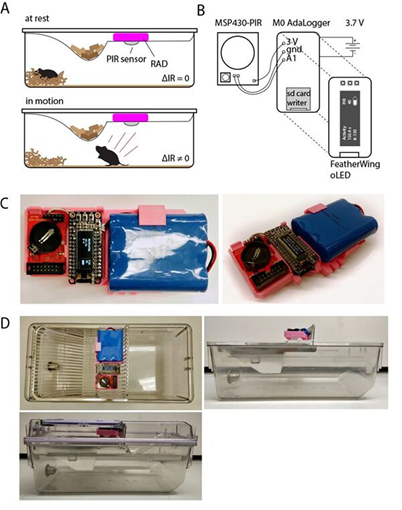

# Experimental design

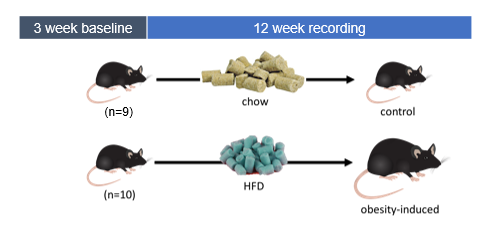

## Import libraries

In [1]:
#importing all libraries needed for handling dataframes and plotting

!pip install seaborn==0.9.0
!pip install RISE

import pandas as pd
import io

import numpy as np

import seaborn as sns

import matplotlib.collections as clt
import matplotlib.pyplot as plt
import os
import math
import datetime
from datetime import datetime

## Concatenate into a single data file

In [2]:
# Data are collected in 2 week intervals for 12 weeks. 
# For visualization, a single continuous data file is preferred so the files are concatenated into a single file here.

df = pd.DataFrame()
files = sorted(os.listdir())
files1 = files[1:170] # selects all CSV files in the working directory
print("Found" + str(len(files1))+ "files.")    #confirm number of files found matches number of data files

# looping through each file to add variables and concatenate
for file in files1:
    print ("Concatenating...", file)
    temp = pd.read_csv(file, parse_dates = True, index_col = "MM:DD:YYYY hh:mm:ss") #outputs the current file being read through the loop - serves as a check
    
    #strip white spaces from column names
    temp.columns = temp.columns.str.strip()

    #Make difference variables
    temp["PIRDiff"] = temp["PIRDuration"].diff()  #create a new "difference" column for each file called PIRDiff
    temp["PIRCountDiff"] = temp["PIRCount"].diff() #create a new "difference" column for each file called PIRCountDiff

    #Make day/night column: if the timepoint is nighttime, the Nighttime column will read "True"
    temp['Nighttime'] = ~np.logical_and((temp.index.hour>=6),(temp.index.hour<18)) # Create a "Nighttime" variable for whether it is daytime or nighttime

    #join each file together in one df 
    df = pd.concat ([df, temp]) 

Found168files.
Concatenating... PIR002_082918_00.CSV
Concatenating... PIR002_091418_00.CSV
Concatenating... PIR002_092418_01.CSV
Concatenating... PIR002_100818_03.CSV
Concatenating... PIR002_101518_00.CSV
Concatenating... PIR002_102918_00.CSV
Concatenating... PIR002_110518_00.CSV
Concatenating... PIR002_111618_01.CSV
Concatenating... PIR002_112618_02.CSV
Concatenating... PIR002_120518_05.CSV
Concatenating... PIR003_082918_00.CSV
Concatenating... PIR003_091418_00.CSV
Concatenating... PIR003_092418_00.CSV
Concatenating... PIR003_100918_00.CSV
Concatenating... PIR003_101518_00.CSV
Concatenating... PIR003_102918_00.CSV
Concatenating... PIR003_111618_02.CSV
Concatenating... PIR003_112618_01.CSV
Concatenating... PIR003_120518_01.CSV
Concatenating... PIR007_082918_00.CSV
Concatenating... PIR007_091418_00.CSV
Concatenating... PIR007_092418_00.CSV
Concatenating... PIR007_100818_00.CSV
Concatenating... PIR007_101518_00.CSV
Concatenating... PIR007_102918_00.CSV
Concatenating... PIR007_110518_00.C

In [3]:
# sort tbe dataframe df by Device and print the head: check to see additional columns are made
df=df.sort_values(by=['Device']) 
df.head()

,Elapsed Time,Device,PIRCount,PIRDuration,BatteryVoltage,PIRDiff,PIRCountDiff,Nighttime
MM:DD:YYYY hh:mm:ss,,,,,,,,
2018-08-29 12:45:25,0:1:0,2,11,9.96,3.54,NaN,NaN,False
2018-11-12 05:53:07,159:56:1,2,6935,6812.29,3.47,0.0,0.0,True
2018-11-12 05:52:07,159:55:1,2,6935,6812.29,3.48,0.0,0.0,True
2018-11-12 05:51:07,159:54:1,2,6935,6812.29,3.47,0.0,0.0,True
2018-11-12 05:50:08,159:53:1,2,6935,6812.29,3.48,0.0,0.0,True


## Add a "group" column to df indicating which group each mouse is in

In [4]:
# For the experiments, there are 2 groups of mice each receiving a different diet for 12 weeks: (1) high fat diet (HFD) 
# (2) regular chow. This information is not included in the CSV file, so a separate column to indicate the condition is needed.

groupsDict = {} # creates a dictionary with the device/mouse number and the group assigned 
groupsDict.update(dict.fromkeys([26,34,15,7,8,3,2,12,27,22], "HFD"))        #keys are mouse IDs that received HFD
groupsDict.update(dict.fromkeys([16,32,21,33,28,14,39,37,19], "chow"))   #keys are mouse IDs that received chow only

df["group"] = df['Device'].map(groupsDict) #adds a column to the dataframe with the diet each mouse received

## Bins df into 1-week time bins

In [5]:
# The device collects data in 1-minute time bins. With respect to a 12-week experiment, 1-min bins are too small. 
# To make the data more manageable and easier to visualize, the data was re-binned into 1-week bins

#set bin width for use with .resample method
bin = "10080min"

#rekey groups into integers for binning
df = df.replace('HFD',1).replace('chow',3)

#Split df into a list "dfs" that contains separate dfs for each mouse
dfs = [rows for _, rows in df.groupby('Device')]

df_binned = pd.DataFrame()
#iterate over all unique device IDs in df["Device"]
for device in range (0, len(pd.unique (df["Device"]))):
  tempdf = pd.DataFrame()
  tempdf = dfs[device].resample(bin).mean()
  #concatenate data back together
  df_binned = pd.concat ([df_binned, tempdf])

#rekey groups back to strings
df_binned["group"] = df_binned["group"].replace(1, 'HFD').replace(3, 'chow')

#drop seconds from df_binned
df_binned.index = df_binned.index.map(lambda t: t.strftime('%Y-%m-%d'))

## Add a column which indicates the week #

In [6]:
#Some data files have different dates due to unexpected battery shortage or additional experiments within the 15-week period.
#Instead of using the raw dates, we calculate the week number of the 15-week period to keep things consistent across all devices.

#define the starting week 
startingweek = df_binned.index[0]
startingweek = datetime.strptime(startingweek, '%Y-%m-%d') #converts string into datetime 
df_binned.index = pd.to_datetime(df_binned.index) #renames the dates
weeksPerBin = 1 #change this to bin into 2, 3, 4 week chunks

#calculate the week number
df_binned["week"] = df_binned.index - startingweek 
df_binned["week"] = df_binned["week"].astype('timedelta64[D]')//(weeksPerBin*7)+1  

#remove NaN values
df_binned_new = df_binned.dropna()

## Plot activity across groups week to week

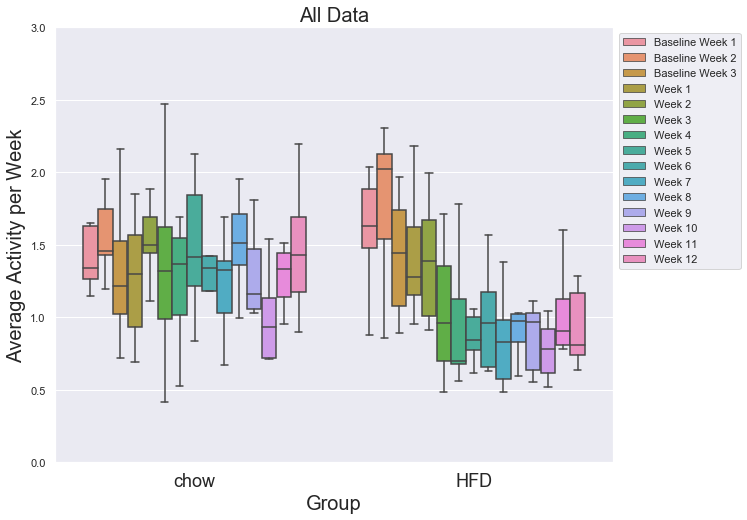

In [7]:
#Create a boxplot for the average activity per group, per week. Allows easier visualization of the overall trends in locomotor activity.

sns.set(rc={'figure.figsize':(10,8)}) #define figure size for easier visualization
ax = sns.boxplot(x="group", y="PIRDiff", hue = "week", data=df_binned, order = ["chow","HFD"], showfliers = False)

#formatting legend
handles, labels = ax.get_legend_handles_labels()
labels = ('Baseline Week 1', 'Baseline Week 2', 'Baseline Week 3', 'Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5', 'Week 6', 'Week 7', 'Week 8', 'Week 9', 'Week 10', 'Week 11', 'Week 12')
l = ax.legend(handles, labels[0:15], bbox_to_anchor=(1, 1))

plt.ylim (0,3)
plt.title("All Data", fontsize=20)
plt.ylabel("Average Activity per Week", fontsize=20)
plt.xlabel("Group", fontsize = 20)
plt.tick_params(axis='x', which='major', labelsize=18)
print ("")

## Resulting plot showing average locomotor activity across time
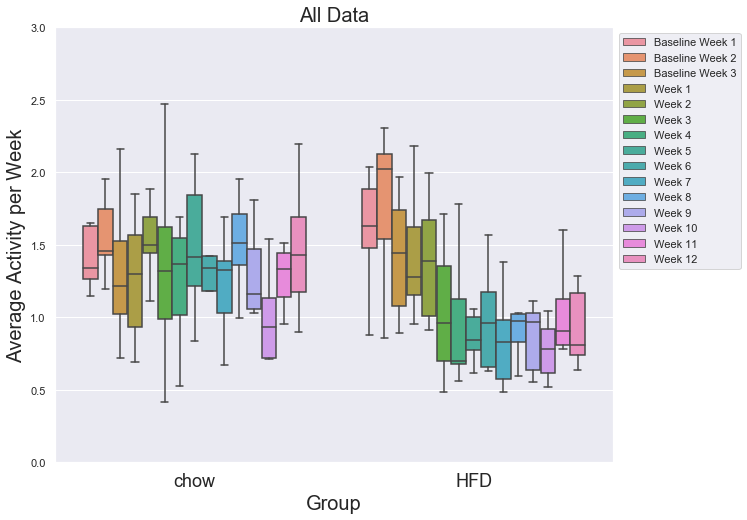